In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-multimodal-image-ct-and-mri' dataset.
Path to dataset files: /kaggle/input/brain-tumor-multimodal-image-ct-and-mri


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
# confirm path structure
for subdir, dirs, files in os.walk(path):
  print(f"{subdir} → {len(files)} files")

/kaggle/input/brain-tumor-multimodal-image-ct-and-mri → 0 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset → 0 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images → 1 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images/Tumor → 3000 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images/Healthy → 2000 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images → 1 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images/Tumor → 2318 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images/Healthy → 2300 files


In [ ]:
DATASET_DIR = os.path.join(path, "Dataset")
CT_DIR = os.path.join(DATASET_DIR, "Brain Tumor CT scan Images")

CT_TUMOR_DIR = os.path.join(CT_DIR, "Tumor")
CT_NORMAL_DIR = os.path.join(CT_DIR, "Healthy")

In [ ]:
import shutil
WORKING_DIR = "/kaggle/working"

CT_ALL_IMAGES_DIR = os.path.join(WORKING_DIR, "CT_ALL_IMAGES_DIR")
os.makedirs(CT_ALL_IMAGES_DIR, exist_ok=True)

print(f"Created writable directory: {CT_ALL_IMAGES_DIR}")

def copy_images_to_new_folder(source_dir, destination_dir):
    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            shutil.copy(os.path.join(source_dir, filename), destination_dir)

print("Copying images...")
copy_images_to_new_folder(CT_TUMOR_DIR, CT_ALL_IMAGES_DIR)
copy_images_to_new_folder(CT_NORMAL_DIR, CT_ALL_IMAGES_DIR)

print(f"Done! All images from '{os.path.basename(CT_TUMOR_DIR)}' and "
      f"'{os.path.basename(CT_NORMAL_DIR)}' copied to "
      f"'{CT_ALL_IMAGES_DIR}'.")

Created writable directory: /kaggle/working/CT_ALL_IMAGES_DIR
Copying images...
Done! All images from 'Tumor' and 'Healthy' copied to '/kaggle/working/CT_ALL_IMAGES_DIR'.


In [ ]:
# create dataframe of ct images with labels (healthy / tumor)
from typing import List, Tuple

# make sure ct_dir is a valid directory
assert os.path.isdir(CT_ALL_IMAGES_DIR), f"Missing CT directory: {CT_ALL_IMAGES_DIR }"

def list_images_with_label(root_dir: str, label_dirs: List[str]) -> pd.DataFrame:
  rows = []
  for f in os.listdir(root_dir):
    if f.lower().endswith((".jpg", ".jpeg", ".png")):
      lower = f.lower()
      if "healthy" in lower:
          label = "healthy"
      elif "tumor" in lower:
          label = "tumor"
      rows.append({
          "path": os.path.join(root_dir, f),
          "label": label
      })
  return pd.DataFrame(rows)

ct_df = list_images_with_label(CT_ALL_IMAGES_DIR , ["Healthy", "Tumor"])
print("CT images:", len(ct_df))
ct_df.head()

CT images: 4618


,path,label
0,/kaggle/working/CT_ALL_IMAGES_DIR/ct_healthy (...,healthy
1,/kaggle/working/CT_ALL_IMAGES_DIR/ct_healthy (...,healthy
2,/kaggle/working/CT_ALL_IMAGES_DIR/ct_healthy (...,healthy
3,/kaggle/working/CT_ALL_IMAGES_DIR/ct_tumor (38...,tumor
4,/kaggle/working/CT_ALL_IMAGES_DIR/ct_healthy (...,healthy


In [ ]:
# more image friendly in general vs. prev preprocessing functions

def resize_img(img, size=(224, 224)):
    return cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)

def clahe_img(img, clip=2.0, tile=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    return clahe.apply(img)

def gaussian_img(img, ksize=(5,5)):
    return cv2.GaussianBlur(img, ksize, 0)

In [ ]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class CTDataset(Dataset):
    def __init__(self, df, label_to_idx):
        self.df = df.reset_index(drop=True)
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]
        label_str = row["label"]
        target = self.label_to_idx[label_str]

        # ---- load image (grayscale) ----
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # (H, W)
        if img is None:
            raise ValueError(f"Failed to read image: {img_path}")

        # ---- preprocessing pipeline ----
        img = resize_img(img, size=(224, 224))
        img = clahe_img(img, clip=2.0, tile=(8, 8))
        img = gaussian_img(img, ksize=(5, 5))

        # ---- scale and convert to 3-channel tensor ----
        img = img.astype(np.float32) / 255.0            # [0,1], (224, 224)
        img = np.repeat(img[np.newaxis, ...], 3, axis=0)  # (3, 224, 224)

        img_tensor = torch.from_numpy(img)              # float32 tensor
        target_tensor = torch.tensor(target, dtype=torch.long)

        return img_tensor, target_tensor


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
from sklearn.model_selection import train_test_split

# map labels to integers
label_to_idx = {"healthy": 0, "tumor": 1}
ct_df["target"] = ct_df["label"].map(label_to_idx)

# 20% hold-out test set (never used in training/val)
trainval_df, test_df = train_test_split(
    ct_df,
    test_size=0.20,
    stratify=ct_df["target"],
    random_state=42,
)

print("Train+Val size:", len(trainval_df))
print("Test size:", len(test_df))


Train+Val size: 3694
Test size: 924


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_folds = 5
num_epochs = 10
batch_size = 32

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(trainval_df["path"], trainval_df["target"])):
    print(f"\n========== Fold {fold+1}/{num_folds} ==========")

    train_df = trainval_df.iloc[train_idx].reset_index(drop=True)
    val_df = trainval_df.iloc[val_idx].reset_index(drop=True)

    # datasets & loaders
    train_dataset = CTDataset(train_df, label_to_idx)
    val_dataset = CTDataset(val_df, label_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # fresh model & optimizer for each fold
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_val_f1 = -1.0
    best_state = None

    for epoch in range(num_epochs):
        # ---- training ----
        model.train()
        running_loss = 0.0
        train_preds = []
        train_targets = []

        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

            _, preds = outputs.max(1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_dataset)
        train_acc = accuracy_score(train_targets, train_preds)

        # ---- validation ----
        model.eval()
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)

                outputs = model(imgs)
                _, preds = outputs.max(1)

                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_targets, val_preds)
        val_f1 = f1_score(val_targets, val_preds, average="binary")

        print(
            f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} "
            f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
        )

        # track best model for this fold
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "val_f1": val_f1,
            }

    print(f"Fold {fold+1} best Val F1: {best_val_f1:.4f}")
    fold_results.append(best_val_f1)

    # save best model
    torch.save(best_state, f"best_cnn_fold{fold+1}.pth")

print("\nCross-validation F1 per fold:", fold_results)
print("Mean F1:", np.mean(fold_results), "Std F1:", np.std(fold_results))



========== Fold 1/5 ==========
Fold 1 Epoch 1/10 - Train Loss: 0.4290, Train Acc: 0.8041, Val Acc: 0.8552, Val F1: 0.8361
Fold 1 Epoch 2/10 - Train Loss: 0.2346, Train Acc: 0.9096, Val Acc: 0.9215, Val F1: 0.9181
Fold 1 Epoch 3/10 - Train Loss: 0.1319, Train Acc: 0.9465, Val Acc: 0.9581, Val F1: 0.9594
Fold 1 Epoch 4/10 - Train Loss: 0.0915, Train Acc: 0.9641, Val Acc: 0.9526, Val F1: 0.9512
Fold 1 Epoch 5/10 - Train Loss: 0.0596, Train Acc: 0.9753, Val Acc: 0.9662, Val F1: 0.9664
Fold 1 Epoch 6/10 - Train Loss: 0.0417, Train Acc: 0.9844, Val Acc: 0.9675, Val F1: 0.9681
Fold 1 Epoch 7/10 - Train Loss: 0.0292, Train Acc: 0.9888, Val Acc: 0.9608, Val F1: 0.9602
Fold 1 Epoch 8/10 - Train Loss: 0.0262, Train Acc: 0.9912, Val Acc: 0.9783, Val F1: 0.9783
Fold 1 Epoch 9/10 - Train Loss: 0.0202, Train Acc: 0.9932, Val Acc: 0.9716, Val F1: 0.9714
Fold 1 Epoch 10/10 - Train Loss: 0.0107, Train Acc: 0.9959, Val Acc: 0.9716, Val F1: 0.9721
Fold 1 best Val F1: 0.9783

========== Fold 2/5 =========

In [ ]:
best_fold_idx = int(np.argmax(fold_results))
best_fold = best_fold_idx + 1
best_ckpt_path = f"best_cnn_fold{best_fold}.pth"

print("Best fold:", best_fold, "F1:", fold_results[best_fold_idx])
print("Checkpoint:", best_ckpt_path)

Best fold: 1 F1: 0.978319783197832
Checkpoint: best_cnn_fold1.pth


Test Accuracy: 0.9718614718614719
Test F1: 0.9721627408993576

Classification report:
              precision    recall  f1-score   support

     healthy       0.98      0.97      0.97       460
       tumor       0.97      0.98      0.97       464

    accuracy                           0.97       924
   macro avg       0.97      0.97      0.97       924
weighted avg       0.97      0.97      0.97       924


Confusion Matrix (Test Set):
[[444  16]
 [ 10 454]]


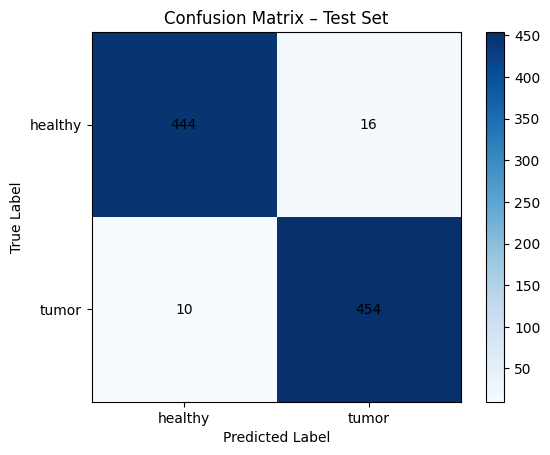

In [ ]:
from sklearn.metrics import confusion_matrix

# rebuild model
best_model = SimpleCNN().to(device)

# load checkpoint
checkpoint = torch.load(best_ckpt_path, map_location=device)
best_model.load_state_dict(checkpoint["model"])
best_model.eval()

# build test dataset + loader
test_dataset = CTDataset(test_df.reset_index(drop=True), label_to_idx)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

from sklearn.metrics import accuracy_score, f1_score, classification_report

all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = best_model(imgs)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_targets, all_preds)
test_f1  = f1_score(all_targets, all_preds, average="binary")

print("Test Accuracy:", test_acc)
print("Test F1:", test_f1)
print("\nClassification report:")
print(classification_report(all_targets, all_preds, target_names=["healthy", "tumor"]))

# ---- Confusion Matrix (Test Set) ----
cm = confusion_matrix(all_targets, all_preds)

print("\nConfusion Matrix (Test Set):")
print(cm)

plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

class_names = ["healthy", "tumor"]

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xticks([0, 1], class_names)
plt.yticks([0, 1], class_names)

plt.show()


In [ ]:
def preprocess_ct(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))

    # CLAHE to improve visibility
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Convert to float [0,1]
    img = img.astype(np.float32) / 255.0

    # Duplicate to 3 channels
    img = np.stack([img, img, img], axis=-1)

    return img


In [ ]:
# map string labels to integers
label_to_idx = {"healthy": 0, "tumor": 1}
ct_df["target"] = ct_df["label"].map(label_to_idx)

# extract paths + labels for visualization
ct_paths = ct_df["path"].values
ct_labels = ct_df["target"].values

In [ ]:
import torch
import torch.nn.functional as F

class CNNCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()

        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out.detach()

    def _save_gradient(self, module, grad_in, grad_out):
        # grad_out[0]: (B, C, H, W)
        self.gradients = grad_out[0].detach()

    def generate(self, x):
        """
        x: (1, 3, H, W)
        returns: CAM as numpy array of shape (H, W) in [0,1]
        """
        out = self.model(x)
        class_idx = torch.argmax(out)

        self.model.zero_grad()
        out[0, class_idx].backward(retain_graph=True)

        A = self.activations[0]
        dA = self.gradients[0]

        weights = dA.mean(dim=[1,2])

        cam = torch.zeros_like(A[0])
        for c, w in enumerate(weights):
            cam += w * A[c]

        cam = F.relu(cam)
        cam = cam / (cam.max() + 1e-6)
        return cam.cpu().numpy()


In [ ]:
def visualize_ct_cam(path, cam_obj):
    img = preprocess_ct(path)
    raw = img[...,0]
    raw_rgb = np.stack([raw, raw, raw], axis=-1)

    tensor = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().to(device)

    cam = cam_obj.generate(tensor)
    cam_resized = cv2.resize(cam, (224,224))

    heat = cv2.applyColorMap((cam_resized*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(raw_rgb.astype(np.uint8), 0.5, heat, 0.5, 0)
    return raw_rgb, heat, overlay


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

all_targets = []
all_probs = []

with torch.no_grad():
    for imgs, ys in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        ys = ys.to(device, non_blocking=True)
        logits = model(imgs)
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of "Tumor"
        all_probs.extend(probs.cpu().numpy().tolist())
        all_targets.extend(ys.cpu().numpy().tolist())

# default threshold 0.5 for class
preds = (np.array(all_probs) >= 0.5).astype(int)

print(classification_report(all_targets, preds, target_names=["healthy","tumor"], digits=4))

cm = confusion_matrix(all_targets, preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["healthy","tumor"], yticklabels=["healthy","tumor"])
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ROC Curve and AUC
fpr, tpr, thr = roc_curve(all_targets, all_probs)
auc = roc_auc_score(all_targets, all_probs)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC (Test)")
plt.legend()
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# recreate architecture
best_model = SimpleCNN().to(device)

# load checkpoint for best fold
checkpoint = torch.load(best_ckpt_path, map_location=device)
best_model.load_state_dict(checkpoint["model"])
best_model.eval()

print("Loaded best model from fold", best_fold,
      "epoch", checkpoint["epoch"],
      "val F1:", checkpoint["val_f1"])

Loaded best model from fold 4 epoch 8 val F1: 0.9849462365591398


In [ ]:
target_layer = best_model.features[6]
ct_cam = CNNCAM(best_model, target_layer)

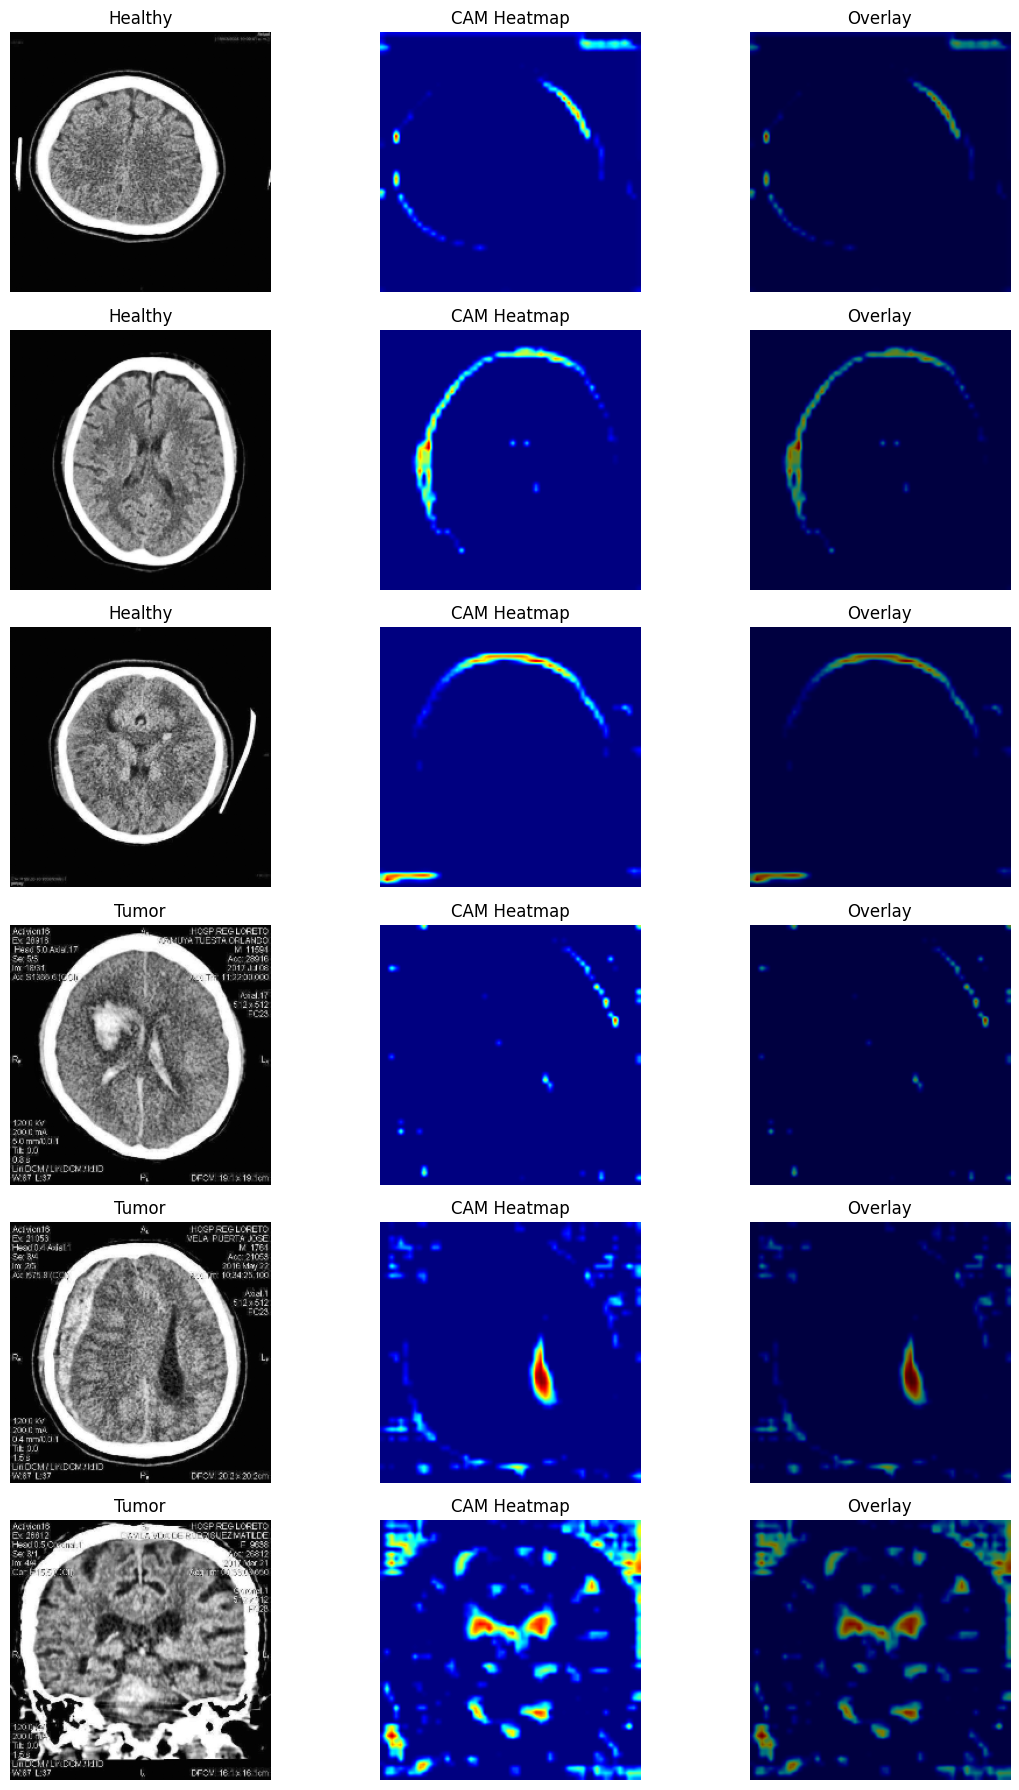

In [ ]:
healthy_idx = np.where(ct_labels == 0)[0]
tumor_idx = np.where(ct_labels == 1)[0]

sample_paths = []
sample_paths += list(ct_paths[np.random.choice(healthy_idx, 3, replace=False)])
sample_paths += list(ct_paths[np.random.choice(tumor_idx, 3, replace=False)])

plt.figure(figsize=(12,18))

for i, p in enumerate(sample_paths):
    raw, heat, overlay = visualize_ct_cam(p, ct_cam)

    label = "Healthy" if i < 3 else "Tumor"

    plt.subplot(6,3,i*3+1); plt.imshow(raw, cmap="gray"); plt.title(label); plt.axis("off")
    plt.subplot(6,3,i*3+2); plt.imshow(heat); plt.title("CAM Heatmap"); plt.axis("off")
    plt.subplot(6,3,i*3+3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def compute_focus_score(cam):
    return np.mean(cam)

In [ ]:
from tqdm import tqdm
from scipy.stats import pearsonr

ct_focus_scores = []
ct_probabilities = []

best_model.eval()

for path in tqdm(ct_paths):
    img = preprocess_ct(path)
    tensor = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().to(device)

    # forward pass — get probability for tumor
    with torch.no_grad():
        logits = best_model(tensor)
        prob = torch.softmax(logits, dim=1)[0,1].item()

    # get CAM
    cam = ct_cam.generate(tensor)
    ct_focus_scores.append(np.mean(cam))
    ct_probabilities.append(prob)

ct_focus_scores = np.array(ct_focus_scores)
ct_probabilities = np.array(ct_probabilities)


100%|██████████| 4618/4618 [00:34<00:00, 133.56it/s]


In [ ]:
ct_focus_healthy = ct_focus_scores[ct_labels == 0]
ct_focus_tumor = ct_focus_scores[ct_labels == 1]

/tmp/ipython-input-4251349952.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ct_focus_healthy, ct_focus_tumor], labels=["Healthy", "Tumor"])


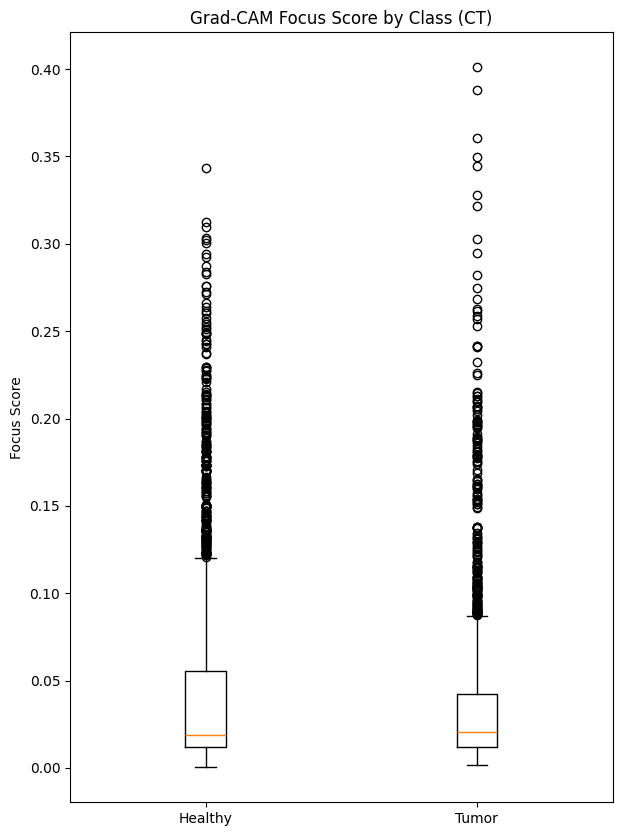

In [ ]:
plt.figure(figsize=(7,10))
plt.boxplot([ct_focus_healthy, ct_focus_tumor], labels=["Healthy", "Tumor"])
plt.title("Grad-CAM Focus Score by Class (CT)")
plt.ylabel("Focus Score")
plt.show()

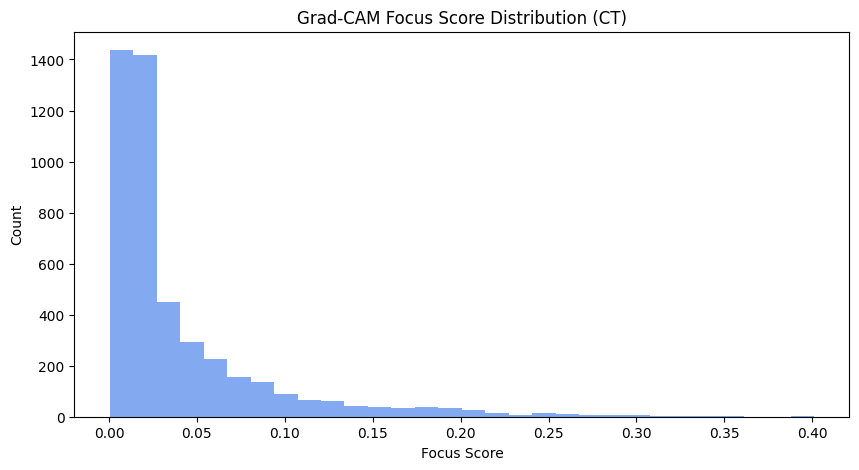

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(ct_focus_scores, bins=30, color="cornflowerblue", alpha=0.8)
plt.title("Grad-CAM Focus Score Distribution (CT)")
plt.xlabel("Focus Score")
plt.ylabel("Count")
plt.show()

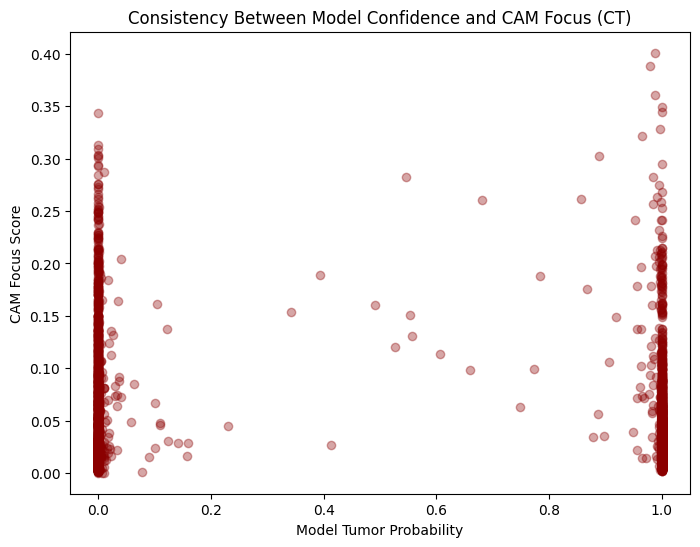

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(ct_probabilities, ct_focus_scores, alpha=0.35, color="darkred")
plt.title("Consistency Between Model Confidence and CAM Focus (CT)")
plt.xlabel("Model Tumor Probability")
plt.ylabel("CAM Focus Score")
plt.show()

In [ ]:
corr, _ = pearsonr(ct_probabilities, ct_focus_scores)

print("\n=== RESNET18 GRAD-CAM SUMMARY (CT) ===")
print(f"Mean CAM Score (ALL):      {ct_focus_scores.mean():.4f}")
print(f"Mean CAM Score (Healthy):  {ct_focus_healthy.mean():.4f}")
print(f"Mean CAM Score (Tumor):    {ct_focus_tumor.mean():.4f}")
print(f"\nCorrelation (CAM vs Tumor Confidence): {corr:.4f}")


=== RESNET18 GRAD-CAM SUMMARY (CT) ===
Mean CAM Score (ALL):      0.0402
Mean CAM Score (Healthy):  0.0441
Mean CAM Score (Tumor):    0.0363

Correlation (CAM vs Tumor Confidence): -0.0824
